<a href="https://colab.research.google.com/github/arthurvale/Sbrt-2025/blob/main/Treinamento_modelos_sbrt_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from sklearn.metrics import recall_score, fbeta_score, confusion_matrix



from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import  RandomForestClassifier, VotingClassifier

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split

from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler,PowerTransformer
from sklearn.pipeline import Pipeline

from sklearn.base import BaseEstimator, TransformerMixin


from scipy import stats
from scipy.stats import boxcox, yeojohnson
import time

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


No treinamento dos modelos cada uma das faixas de velocidade seguiu a seguinte metodologia para avaliação dos modelos.

1. Pipeline de pre-processamento para KNN;
2. Ajuste fino dos parâmetros das classes de modelos KNN e Random Forest com Grid Scearh;
3. Avaliar a generalização dos modelos para outros conjuntos de treino-teste, ou seja, através de validação cruzada;

# Importação da Base de Dados processada

In [ ]:
df_cop = pd.read_parquet('/content/drive/MyDrive/5G/dataframe_final.parquet')
df_speed_baixa = df_cop[df_cop['Speed'] < 10].copy()
df_speed_media = df_cop[(df_cop['Speed'] >= 10) & (df_cop['Speed'] < 40)].copy()
df_speed_alta = df_cop[df_cop['Speed'] >= 40].copy()

# 1. Pipeline de pre processamento

A estrutura proposta identifica a presença de outliers a partir do método do intervalo interquartil. Se existirem outliers, os valores desta feature sao analisados, se forem exclusivamente positivos a transformação de Box-Cox é usada, caso contrário a transformação Yae-Johnson é usada.  

Os parâmetros de transformação, ${\lambda}$ de Box-Cox ou Yeo-Johnson, são ajustados exclusivamente durante a fase de treinamento (fit), utilizando apenas os dados de treino, e posteriormente aplicados na fase de transformação (transform), desta maneira nao ocorre o vazamento dos dados de teste nos dados de treino.

In [ ]:
class OutlierTrnansform(BaseEstimator, TransformerMixin):
    def __init__(self, method='yeo-johnson', columns=None, epsilon=1e-6):
        self.method = method
        self.columns = columns
        self.epsilon = epsilon
        self.transformers_ = {}
        self.columns_to_transform_ = []
        self.epsilons_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()
        if self.columns is None:
            self.columns = X.columns
        for col in self.columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = X[(X[col] < lower_bound) | (X[col] > upper_bound)]

            if not outliers.empty:
                self.columns_to_transform_.append(col)
                method = self.method
                if method == 'auto':
                    method = 'box-cox' if (X[col] >= 0).all() else 'yeo-johnson'
                if method == 'box-cox':
                    min_val = X[col].min()
                    if min_val <= 0:
                        self.epsilons_[col] = abs(min_val) + self.epsilon
                        X[col] = X[col] + self.epsilons_[col]
                pt = PowerTransformer(method=method)
                pt.fit(X[[col]])
                self.transformers_[col] = (pt, method)
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col in self.columns_to_transform_:
            if col in self.transformers_:
                pt, method = self.transformers_[col]
                if method == 'box-cox' and col in self.epsilons_:
                    X[col] = X[col] + self.epsilons_[col]
                X[col] = pt.transform(X[[col]]).flatten()
        return X


In [ ]:
preprocessor_outlier = ColumnTransformer(
    transformers=[
        ('speed', OutlierTrnansform(method='box-cox', columns=['Speed']), ['Speed']),
        ('signal', OutlierTrnansform(method='yeo-johnson', columns=['SS_PBCH-RSRQ', 'SS_PBCH-RePower']),
         ['SS_PBCH-RSRQ', 'SS_PBCH-RePower'])
    ],
    remainder='passthrough'
)

O objeto: 'pipeline_completa', realiza a transformação dos outliers, em seguida aplica uma normalização para que todas as features estejam na mesma escala. Por fim treina o modelo, sendo usada no treinamento dos modelos de KNN que sao sensiveis a esclaa e a outliers. Já 'pipeline_simplificada', apenas treina o modelo, snedo aplicada no Random Forest, que nao e sensivel a escalas diferentes e outiers.

In [ ]:
pipeline_completa = Pipeline([
    ('preprocessor', preprocessor_outlier),
    ('scaler', MinMaxScaler()),
    ('model', None)
])

pipeline_simplificada = Pipeline([
    ('model', None)
])

# Fine Tunning

### Velocidades Baixas

In [ ]:
y=df_speed_baixa['SSBIdx']
X=df_speed_baixa.drop(columns=['SSBIdx'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=13
)

#### KNN

In [ ]:
from sklearn.model_selection import GridSearchCV



param_grid_knn = {
    'model__n_neighbors': [3, 5, 7],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree']
}

grid_search_knn = GridSearchCV(
    pipeline_completa.set_params(model=KNeighborsClassifier()),
    param_grid=param_grid_knn,
    cv=3,
    scoring='recall_macro'
)

In [ ]:
grid_search_knn.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('speed',
                                                                         OutlierTrnansform(columns=['Speed'],
                                                                                           method='box-cox'),
                                                                         ['Speed']),
                                                                        ('signal',
                                                                         OutlierTrnansform(columns=['SS_PBCH-RSRQ',
                                                                                                    'SS_PBCH-RePower']),
                                                                         ['SS_PBCH-RSRQ',
                                                                          'SS_PBCH-RePower'])])),
                                       ('scaler', MinMaxScaler()),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree'],
                         'model__n_neighbors': [3, 5, 7],
                         'model__weights': ['uniform', 'distance']},
             scoring='recall_macro')

In [ ]:
print("Melhor modelo KNN:")
print(grid_search_knn.best_params_)
print("Melhor pontuação de Recall")
print(grid_search_knn.best_score_)

Melhor modelo KNN:
{'model__algorithm': 'kd_tree', 'model__n_neighbors': 5, 'model__weights': 'distance'}
Melhor pontuação de Recall
0.8645877101676218


#### Random Forest

In [ ]:
param_grid_rf = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [10, 20],
    'model__max_features':["sqrt", "log2"],
    'model__class_weight':["balanced"]
}

grid_search_rf = GridSearchCV(
    pipeline_simplificada.set_params(model=RandomForestClassifier()),
    param_grid=param_grid_rf,
    cv=3,
    scoring='recall_macro'
)

grid_search_rf.fit(X_train, y_train)
print("Melhor modelo Random Forest:")
print(grid_search_rf.best_params_)
print("Melhor pontuação de Recall")
print(grid_search_rf.best_score_)


Melhor modelo Nayve Bayes:
{'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__n_estimators': 100}
Melhor pontuação de Recall
0.8948266317905139


### Velocidades Médias

In [ ]:
y=df_speed_media['SSBIdx']
X=df_speed_media.drop(columns=['SSBIdx'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=13
)

#### KNN

In [ ]:
param_grid_knn = {
    'model__n_neighbors': [3, 5, 7],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree']
}

grid_search_knn = GridSearchCV(
    pipeline_completa.set_params(model=KNeighborsClassifier()),
    param_grid=param_grid_knn,
    cv=3,
    scoring='recall_macro'
)
grid_search_knn.fit(X_train, y_train)
print("Melhor modelo KNN:")
print(grid_search_knn.best_params_)
print("Melhor pontuação de Recall")
print(grid_search_knn.best_score_)

Melhor modelo KNN:
{'model__algorithm': 'ball_tree', 'model__n_neighbors': 7, 'model__weights': 'distance'}
Melhor pontuação de Recall
0.8391912181853017


#### Random Forest

In [ ]:
param_grid_rf = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [10, 20],
    'model__max_features':["sqrt", "log2"],
    'model__class_weight':["balanced"]
}

grid_search_rf = GridSearchCV(
    pipeline_simplificada.set_params(model=RandomForestClassifier()),
    param_grid=param_grid_rf,
    cv=3,
    scoring='recall_macro'
)

grid_search_rf.fit(X_train, y_train)
print("Melhor modelo Random Forest:")
print(grid_search_rf.best_params_)
print("Melhor pontuação de Recall")
print(grid_search_rf.best_score_)

Melhor modelo Random Forest:
{'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__n_estimators': 100}
Melhor pontuação de Recall
0.8687832639401698


### Velocidades Altas

In [ ]:
y=df_speed_alta['SSBIdx']
X=df_speed_alta.drop(columns=['SSBIdx'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=13
)

#### KNN

In [ ]:
param_grid_knn = {
    'model__n_neighbors': [3, 5, 7],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree']
}

grid_search_knn = GridSearchCV(
    pipeline_completa.set_params(model=KNeighborsClassifier()),
    param_grid=param_grid_knn,
    cv=3,
    scoring='recall_macro'
)
grid_search_knn.fit(X_train, y_train)
print("Melhor modelo KNN:")
print(grid_search_knn.best_params_)
print("Melhor pontuação de Recall")
print(grid_search_knn.best_score_)

Melhor modelo KNN:
{'model__algorithm': 'ball_tree', 'model__n_neighbors': 3, 'model__weights': 'distance'}
Melhor pontuação de Recall
0.8186413628134698


#### Random Forest

In [ ]:
param_grid_rf = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [10, 20],
    'model__max_features':["sqrt", "log2"],
    'model__class_weight':["balanced"]
}

grid_search_rf = GridSearchCV(
    pipeline_simplificada.set_params(model=RandomForestClassifier()),
    param_grid=param_grid_rf,
    cv=3,
    scoring='recall_macro'
)

grid_search_rf.fit(X_train, y_train)
print("Melhor modelo Random Forest:")
print(grid_search_rf.best_params_)
print("Melhor pontuação de Recall")
print(grid_search_rf.best_score_)

Melhor modelo Random Forest:
{'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__n_estimators': 100}
Melhor pontuação de Recall
0.8532309271115271


# Validação cruzada

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Velocidades Baixas

In [ ]:
y=df_speed_baixa['SSBIdx']
X=df_speed_baixa.drop(columns=['SSBIdx'])

In [ ]:
pipeline_rf = Pipeline([
    ('model', RandomForestClassifier(
        class_weight='balanced',
        max_depth=20,
        max_features='sqrt',
        n_estimators=100,
        random_state=42
    ))
])

pipeline_knn = Pipeline([
    ('preprocessor', preprocessor_outlier),
    ('scaler', MinMaxScaler()),
    ('model', KNeighborsClassifier(
        algorithm='kd_tree',
        n_neighbors=5,
        weights='distance'
    ))
])

voting = VotingClassifier(
    estimators=[
        ('knn_pipeline', pipeline_knn),
        ('rf_pipeline', pipeline_rf)
    ],
    voting='soft'
)

#### Random Forest

In [ ]:
recall_scores = []
f2_scores = []
prediction_times = []
all_y_true = []
all_y_pred = []


for train_idx, test_idx in cv.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    cloned_pipeline = clone(pipeline_rf)
    cloned_pipeline.fit(X_train_fold, y_train_fold)

    start_time = time.time()
    y_pred_fold = cloned_pipeline.predict(X_test_fold)
    fold_prediction_time = time.time() - start_time

    n_samples = len(X_test_fold)
    prediction_times.append(fold_prediction_time / n_samples)


    recall_scores.append(recall_score(y_test_fold, y_pred_fold, average='macro'))
    f2_scores.append(fbeta_score(y_test_fold, y_pred_fold, average='macro', beta=2))


    all_y_true.extend(y_test_fold)
    all_y_pred.extend(y_pred_fold)


results = {
    'Recall_macro (Média)': np.mean(recall_scores),
    'Recall_macro (Desvio Padrão)': np.std(recall_scores),
    'F2-Score_macro (Média)': np.mean(f2_scores),
    'F2-Score_macro (Desvio Padrão)': np.std(f2_scores),
    'Tempo de predição por amostra (Média)': np.mean(prediction_times) * 1000,  # ms
    'Tempo de predição por amostra (Desvio Padrão)': np.std(prediction_times) * 1000
}


print("Resultados da Validação Cruzada:")
for key, value in results.items():
    print(f"{key}: {value:.4f}")


Resultados da Validação Cruzada:
Recall_macro (Média): 0.9276
Recall_macro (Desvio Padrão): 0.0010
F2-Score_macro (Média): 0.9268
F2-Score_macro (Desvio Padrão): 0.0010
Tempo de predição por amostra (Média): 0.0314
Tempo de predição por amostra (Desvio Padrão): 0.0129

Matriz de Confusão Consolidada:
[[67560   999   527   439   359   396   395   567]
 [  297 31307   634   383   288   237   287   270]
 [  287   562 34448   713   405   231   313   323]
 [  192   366   761 31590   650   238   285   320]
 [  186   284   439   624 28595   383   268   372]
 [  177   308   300   278   482 30602   535   390]
 [  221   319   280   314   226   455 27956   439]
 [  249   307   274   247   283   262   345 27334]]


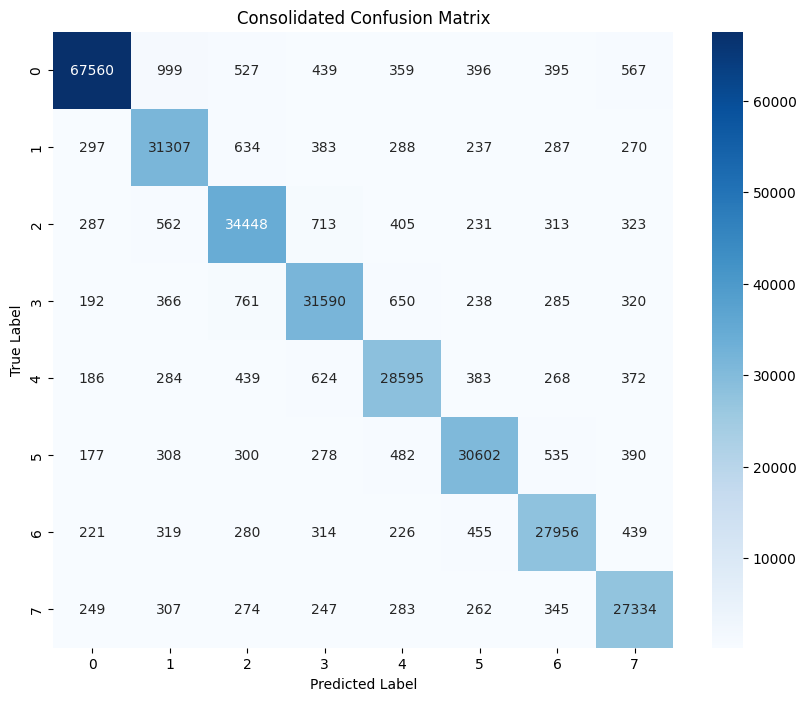

In [ ]:
conf_matrix = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Consolidated Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### KNN

Resultados da Validação Cruzada:
Recall_macro (Média): 0.9264
Recall_macro (Desvio Padrão): 0.0006
F2-Score_macro (Média): 0.9263
F2-Score_macro (Desvio Padrão): 0.0006
Tempo de predição por amostra (Média): 0.0119
Tempo de predição por amostra (Desvio Padrão): 0.0022


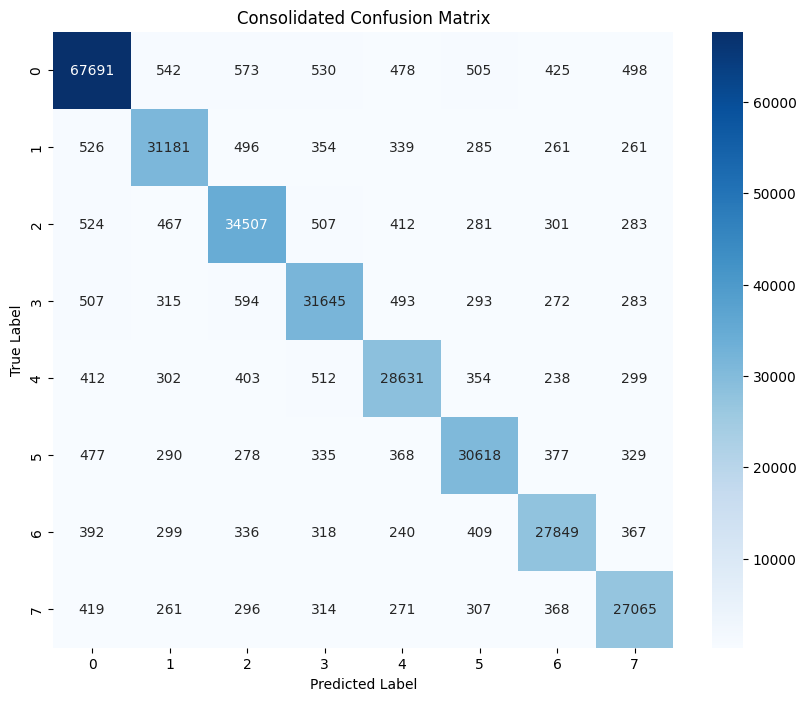

In [ ]:
recall_scores = []
f2_scores = []
prediction_times = []
all_y_true = []
all_y_pred = []


for train_idx, test_idx in cv.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    cloned_pipeline = clone(pipeline_knn)
    cloned_pipeline.fit(X_train_fold, y_train_fold)

    start_time = time.time()
    y_pred_fold = cloned_pipeline.predict(X_test_fold)
    fold_prediction_time = time.time() - start_time

    n_samples = len(X_test_fold)
    prediction_times.append(fold_prediction_time / n_samples)


    recall_scores.append(recall_score(y_test_fold, y_pred_fold, average='macro'))
    f2_scores.append(fbeta_score(y_test_fold, y_pred_fold, average='macro', beta=2))


    all_y_true.extend(y_test_fold)
    all_y_pred.extend(y_pred_fold)


results = {
    'Recall_macro (Média)': np.mean(recall_scores),
    'Recall_macro (Desvio Padrão)': np.std(recall_scores),
    'F2-Score_macro (Média)': np.mean(f2_scores),
    'F2-Score_macro (Desvio Padrão)': np.std(f2_scores),
    'Tempo de predição por amostra (Média)': np.mean(prediction_times) * 1000,
    'Tempo de predição por amostra (Desvio Padrão)': np.std(prediction_times) * 1000
}


print("Resultados da Validação Cruzada:")
for key, value in results.items():
    print(f"{key}: {value:.4f}")


conf_matrix = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Consolidated Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Essemble (soft)


Resultados da Validação Cruzada com VotingClassifier:
Recall_macro (Média): 0.9353
Recall_macro (Desvio Padrão): 0.0002
F2-Score_macro (Média): 0.9353
F2-Score_macro (Desvio Padrão): 0.0002
Tempo de predição por amostra (Média): 0.0346
Tempo de predição por amostra (Desvio Padrão): 0.0051


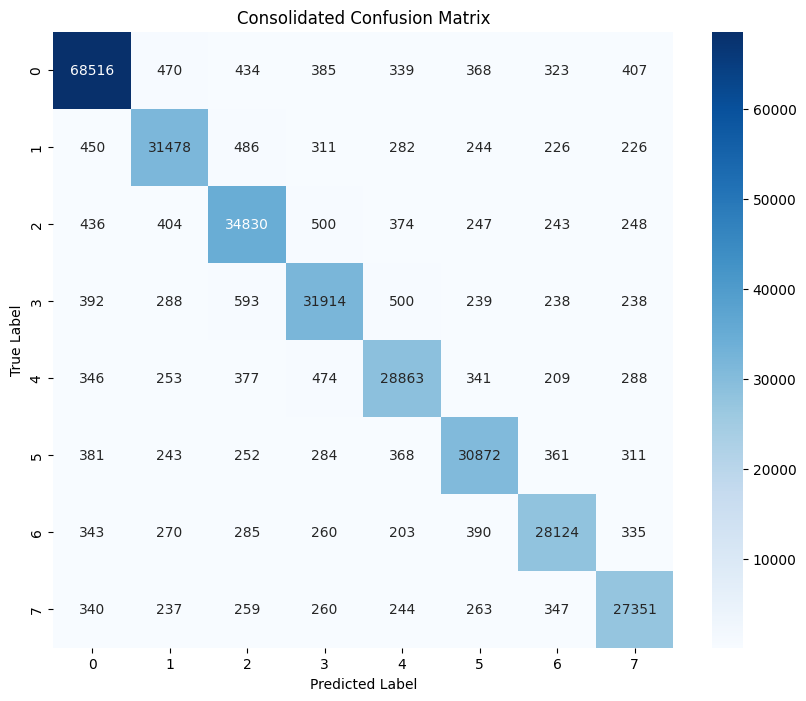

In [ ]:
recall_scores = []
f2_scores = []
prediction_times = []
all_y_true = []
all_y_pred = []

for train_idx, test_idx in cv.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    voting_clone = clone(voting)
    voting_clone.fit(X_train_fold, y_train_fold)

    start_time = time.time()
    y_pred_fold = voting_clone.predict(X_test_fold)
    fold_prediction_time = time.time() - start_time
    prediction_times.append(fold_prediction_time / len(X_test_fold))

    recall_scores.append(recall_score(y_test_fold, y_pred_fold, average='macro'))
    f2_scores.append(fbeta_score(y_test_fold, y_pred_fold, average='macro', beta=2))
    all_y_true.extend(y_test_fold)
    all_y_pred.extend(y_pred_fold)


results = {
    'Recall_macro (Média)': np.mean(recall_scores),
    'Recall_macro (Desvio Padrão)': np.std(recall_scores),
    'F2-Score_macro (Média)': np.mean(f2_scores),
    'F2-Score_macro (Desvio Padrão)': np.std(f2_scores),
    'Tempo de predição por amostra (Média)': np.mean(prediction_times) * 1000,
    'Tempo de predição por amostra (Desvio Padrão)': np.std(prediction_times) * 1000
}

print("\nResultados da Validação Cruzada com VotingClassifier:")
for key, value in results.items():
    print(f"{key}: {value:.4f}")

conf_matrix = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Consolidated Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Velocidades Médias

In [ ]:
y=df_speed_media['SSBIdx']
X=df_speed_media.drop(columns=['SSBIdx'])

In [ ]:
pipeline_rf = Pipeline([
    ('model', RandomForestClassifier(
        class_weight='balanced',
        max_depth=20,
        max_features='sqrt',
        n_estimators=100,
        random_state=42
    ))
])



pipeline_knn = Pipeline([
    ('preprocessor', preprocessor_outlier),
    ('scaler', MinMaxScaler()),
    ('model', KNeighborsClassifier(
        algorithm='ball_tree',
        n_neighbors=7,
        weights='distance'
    ))
])

voting = VotingClassifier(
    estimators=[
        ('knn_pipeline', pipeline_knn),
        ('rf_pipeline', pipeline_rf)
    ],
    voting='soft'
)

#### Random Forest

Resultados da Validação Cruzada:
Recall_macro (Média): 0.9276
Recall_macro (Desvio Padrão): 0.0010
F2-Score_macro (Média): 0.9268
F2-Score_macro (Desvio Padrão): 0.0010
Tempo de predição por amostra (Média): 0.0291
Tempo de predição por amostra (Desvio Padrão): 0.0111


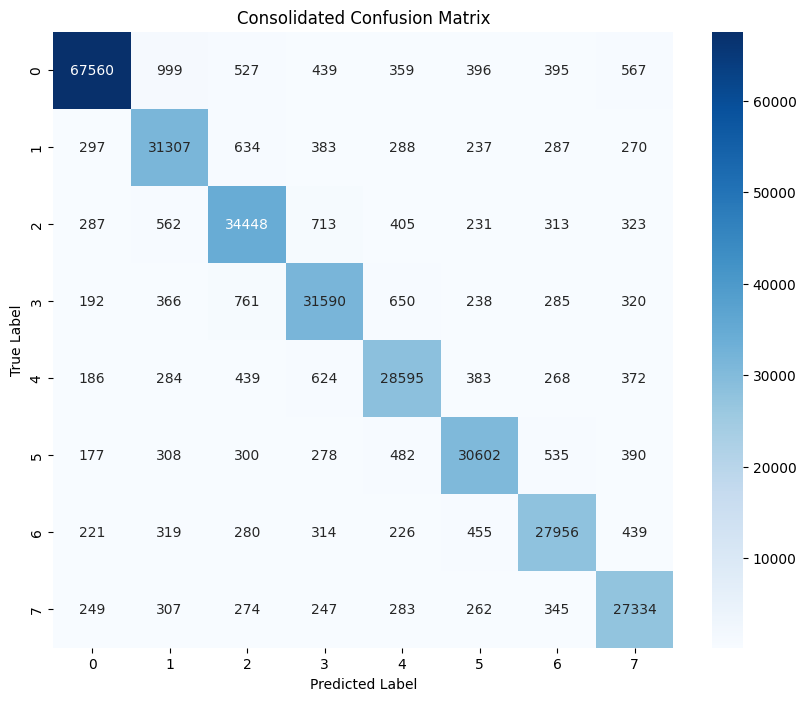

In [ ]:
recall_scores = []
f2_scores = []
prediction_times = []
all_y_true = []
all_y_pred = []


for train_idx, test_idx in cv.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    cloned_pipeline = clone(pipeline_rf)
    cloned_pipeline.fit(X_train_fold, y_train_fold)

    start_time = time.time()
    y_pred_fold = cloned_pipeline.predict(X_test_fold)
    fold_prediction_time = time.time() - start_time

    n_samples = len(X_test_fold)
    prediction_times.append(fold_prediction_time / n_samples)


    recall_scores.append(recall_score(y_test_fold, y_pred_fold, average='macro'))
    f2_scores.append(fbeta_score(y_test_fold, y_pred_fold, average='macro', beta=2))


    all_y_true.extend(y_test_fold)
    all_y_pred.extend(y_pred_fold)


results = {
    'Recall_macro (Média)': np.mean(recall_scores),
    'Recall_macro (Desvio Padrão)': np.std(recall_scores),
    'F2-Score_macro (Média)': np.mean(f2_scores),
    'F2-Score_macro (Desvio Padrão)': np.std(f2_scores),
    'Tempo de predição por amostra (Média)': np.mean(prediction_times) * 1000,  # ms
    'Tempo de predição por amostra (Desvio Padrão)': np.std(prediction_times) * 1000
}


print("Resultados da Validação Cruzada:")
for key, value in results.items():
    print(f"{key}: {value:.4f}")

conf_matrix = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Consolidated Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### KNN

Resultados da Validação Cruzada:
Recall_macro (Média): 0.9263
Recall_macro (Desvio Padrão): 0.0009
F2-Score_macro (Média): 0.9262
F2-Score_macro (Desvio Padrão): 0.0009
Tempo de predição por amostra (Média): 0.1116
Tempo de predição por amostra (Desvio Padrão): 0.0126


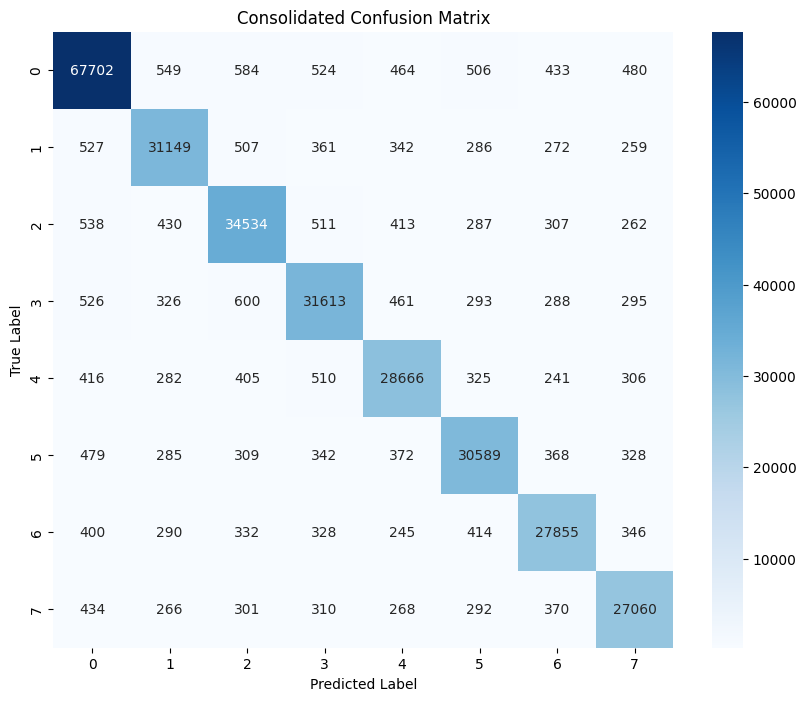

In [ ]:
recall_scores = []
f2_scores = []
prediction_times = []
all_y_true = []
all_y_pred = []


for train_idx, test_idx in cv.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    cloned_pipeline = clone(pipeline_knn)
    cloned_pipeline.fit(X_train_fold, y_train_fold)

    start_time = time.time()
    y_pred_fold = cloned_pipeline.predict(X_test_fold)
    fold_prediction_time = time.time() - start_time

    n_samples = len(X_test_fold)
    prediction_times.append(fold_prediction_time / n_samples)


    recall_scores.append(recall_score(y_test_fold, y_pred_fold, average='macro'))
    f2_scores.append(fbeta_score(y_test_fold, y_pred_fold, average='macro', beta=2))


    all_y_true.extend(y_test_fold)
    all_y_pred.extend(y_pred_fold)


results = {
    'Recall_macro (Média)': np.mean(recall_scores),
    'Recall_macro (Desvio Padrão)': np.std(recall_scores),
    'F2-Score_macro (Média)': np.mean(f2_scores),
    'F2-Score_macro (Desvio Padrão)': np.std(f2_scores),
    'Tempo de predição por amostra (Média)': np.mean(prediction_times) * 1000,
    'Tempo de predição por amostra (Desvio Padrão)': np.std(prediction_times) * 1000
}


print("Resultados da Validação Cruzada:")
for key, value in results.items():
    print(f"{key}: {value:.4f}")


conf_matrix = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Consolidated Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Essemble (soft)


Resultados da Validação Cruzada com VotingClassifier:
Recall_macro (Média): 0.9357
Recall_macro (Desvio Padrão): 0.0003
F2-Score_macro (Média): 0.9357
F2-Score_macro (Desvio Padrão): 0.0003
Tempo de predição por amostra (Média): 0.1850
Tempo de predição por amostra (Desvio Padrão): 0.0520


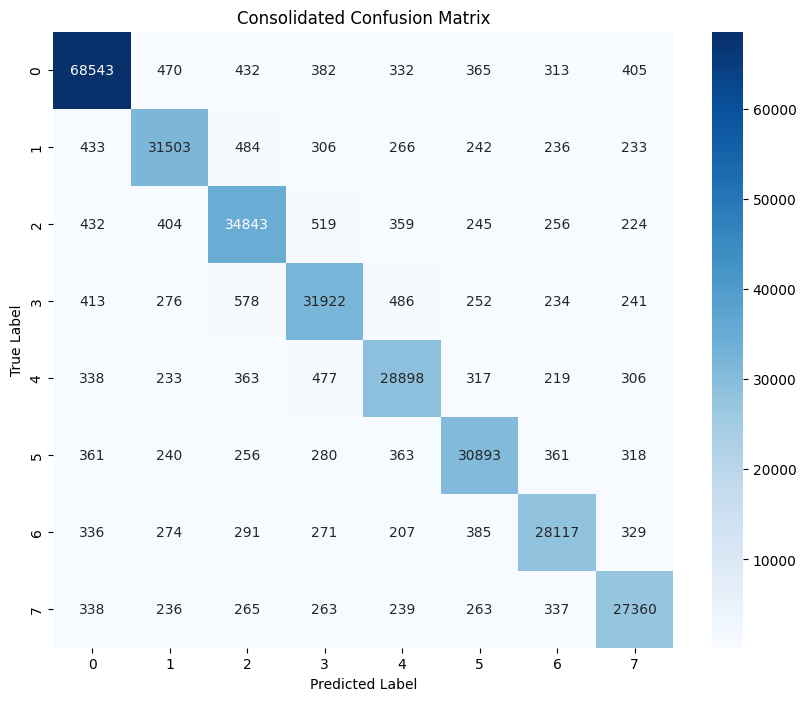

In [ ]:
recall_scores = []
f2_scores = []
prediction_times = []
all_y_true = []
all_y_pred = []

for train_idx, test_idx in cv.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    voting_clone = clone(voting)
    voting_clone.fit(X_train_fold, y_train_fold)

    start_time = time.time()
    y_pred_fold = voting_clone.predict(X_test_fold)
    fold_prediction_time = time.time() - start_time
    prediction_times.append(fold_prediction_time / len(X_test_fold))

    recall_scores.append(recall_score(y_test_fold, y_pred_fold, average='macro'))
    f2_scores.append(fbeta_score(y_test_fold, y_pred_fold, average='macro', beta=2))
    all_y_true.extend(y_test_fold)
    all_y_pred.extend(y_pred_fold)


results = {
    'Recall_macro (Média)': np.mean(recall_scores),
    'Recall_macro (Desvio Padrão)': np.std(recall_scores),
    'F2-Score_macro (Média)': np.mean(f2_scores),
    'F2-Score_macro (Desvio Padrão)': np.std(f2_scores),
    'Tempo de predição por amostra (Média)': np.mean(prediction_times) * 1000,
    'Tempo de predição por amostra (Desvio Padrão)': np.std(prediction_times) * 1000
}

print("\nResultados da Validação Cruzada com VotingClassifier:")
for key, value in results.items():
    print(f"{key}: {value:.4f}")

conf_matrix = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Consolidated Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Velocidades Altas

In [ ]:
y=df_speed_alta['SSBIdx']
X=df_speed_alta.drop(columns=['SSBIdx'])

In [ ]:
pipeline_rf = Pipeline([
    ('model', RandomForestClassifier(
        class_weight='balanced',
        max_depth=20,
        max_features='sqrt',
        n_estimators=100,
        random_state=42
    ))
])




pipeline_knn = Pipeline([
    ('preprocessor', preprocessor_outlier),
    ('scaler', MinMaxScaler()),
    ('model', KNeighborsClassifier(
        algorithm='ball_tree',
        n_neighbors=3,
        weights='distance'
    ))
])



voting = VotingClassifier(
    estimators=[
        ('knn_pipeline', pipeline_knn),
        ('rf_pipeline', pipeline_rf)
    ],
    voting='soft'
)

#### Random Forest

Resultados da Validação Cruzada:
Recall_macro (Média): 0.9085
Recall_macro (Desvio Padrão): 0.0022
F2-Score_macro (Média): 0.9083
F2-Score_macro (Desvio Padrão): 0.0023
Tempo de predição por amostra (Média): 0.0288
Tempo de predição por amostra (Desvio Padrão): 0.0071


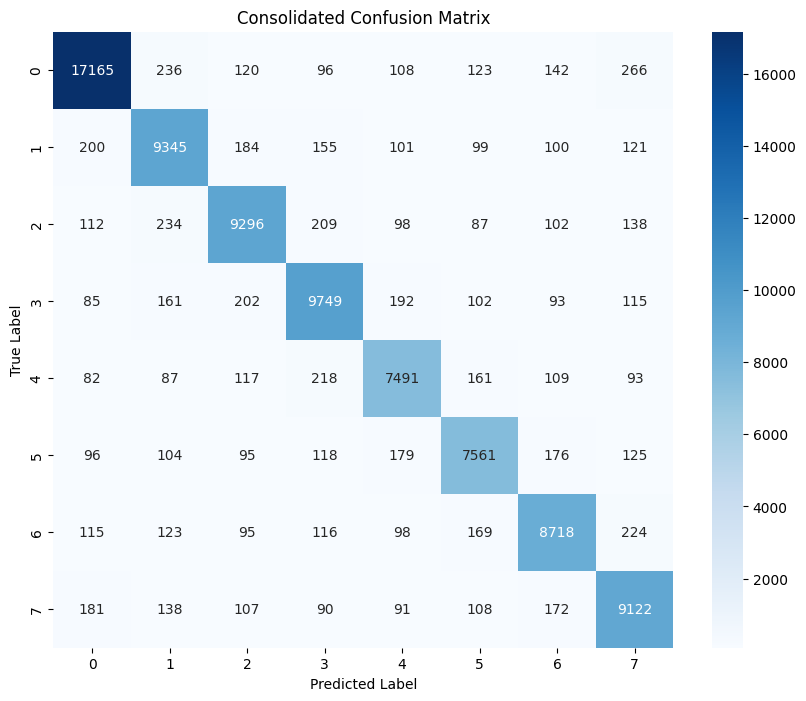

In [ ]:
recall_scores = []
f2_scores = []
prediction_times = []
all_y_true = []
all_y_pred = []


for train_idx, test_idx in cv.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    cloned_pipeline = clone(pipeline_rf)
    cloned_pipeline.fit(X_train_fold, y_train_fold)

    start_time = time.time()
    y_pred_fold = cloned_pipeline.predict(X_test_fold)
    fold_prediction_time = time.time() - start_time

    n_samples = len(X_test_fold)
    prediction_times.append(fold_prediction_time / n_samples)


    recall_scores.append(recall_score(y_test_fold, y_pred_fold, average='macro'))
    f2_scores.append(fbeta_score(y_test_fold, y_pred_fold, average='macro', beta=2))


    all_y_true.extend(y_test_fold)
    all_y_pred.extend(y_pred_fold)


results = {
    'Recall_macro (Média)': np.mean(recall_scores),
    'Recall_macro (Desvio Padrão)': np.std(recall_scores),
    'F2-Score_macro (Média)': np.mean(f2_scores),
    'F2-Score_macro (Desvio Padrão)': np.std(f2_scores),
    'Tempo de predição por amostra (Média)': np.mean(prediction_times) * 1000,  # ms
    'Tempo de predição por amostra (Desvio Padrão)': np.std(prediction_times) * 1000
}


print("Resultados da Validação Cruzada:")
for key, value in results.items():
    print(f"{key}: {value:.4f}")

conf_matrix = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Consolidated Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### KNN

Resultados da Validação Cruzada:
Recall_macro (Média): 0.8916
Recall_macro (Desvio Padrão): 0.0016
F2-Score_macro (Média): 0.8915
F2-Score_macro (Desvio Padrão): 0.0016
Tempo de predição por amostra (Média): 0.0539
Tempo de predição por amostra (Desvio Padrão): 0.0289


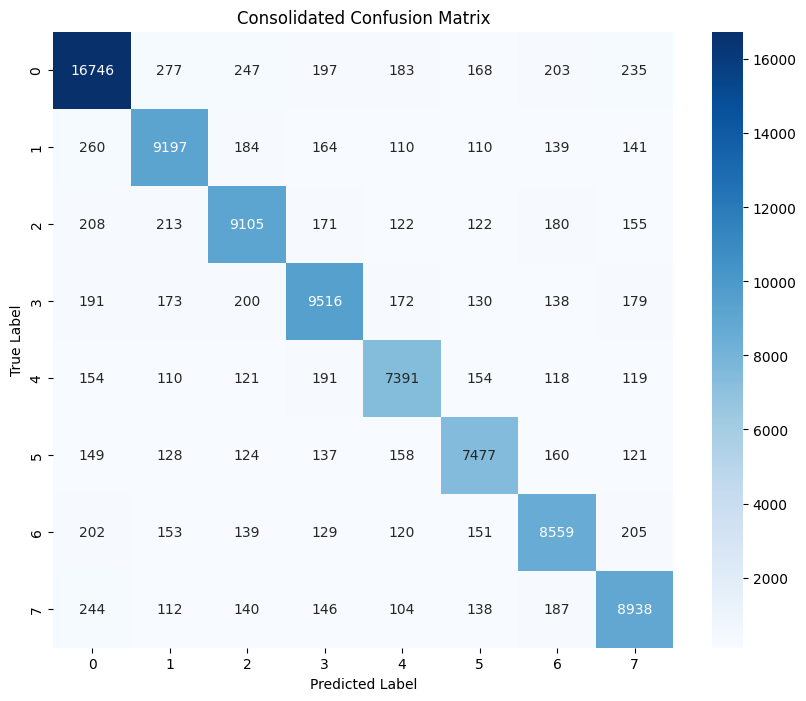

In [ ]:
recall_scores = []
f2_scores = []
prediction_times = []
all_y_true = []
all_y_pred = []


for train_idx, test_idx in cv.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    cloned_pipeline = clone(pipeline_knn)
    cloned_pipeline.fit(X_train_fold, y_train_fold)

    start_time = time.time()
    y_pred_fold = cloned_pipeline.predict(X_test_fold)
    fold_prediction_time = time.time() - start_time

    n_samples = len(X_test_fold)
    prediction_times.append(fold_prediction_time / n_samples)


    recall_scores.append(recall_score(y_test_fold, y_pred_fold, average='macro'))
    f2_scores.append(fbeta_score(y_test_fold, y_pred_fold, average='macro', beta=2))


    all_y_true.extend(y_test_fold)
    all_y_pred.extend(y_pred_fold)


results = {
    'Recall_macro (Média)': np.mean(recall_scores),
    'Recall_macro (Desvio Padrão)': np.std(recall_scores),
    'F2-Score_macro (Média)': np.mean(f2_scores),
    'F2-Score_macro (Desvio Padrão)': np.std(f2_scores),
    'Tempo de predição por amostra (Média)': np.mean(prediction_times) * 1000,
    'Tempo de predição por amostra (Desvio Padrão)': np.std(prediction_times) * 1000
}


print("Resultados da Validação Cruzada:")
for key, value in results.items():
    print(f"{key}: {value:.4f}")


conf_matrix = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Consolidated Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Essemble (soft)


Resultados da Validação Cruzada com VotingClassifier:
Recall_macro (Média): 0.8982
Recall_macro (Desvio Padrão): 0.0013
F2-Score_macro (Média): 0.8982
F2-Score_macro (Desvio Padrão): 0.0012
Tempo de predição por amostra (Média): 0.0796
Tempo de predição por amostra (Desvio Padrão): 0.0178


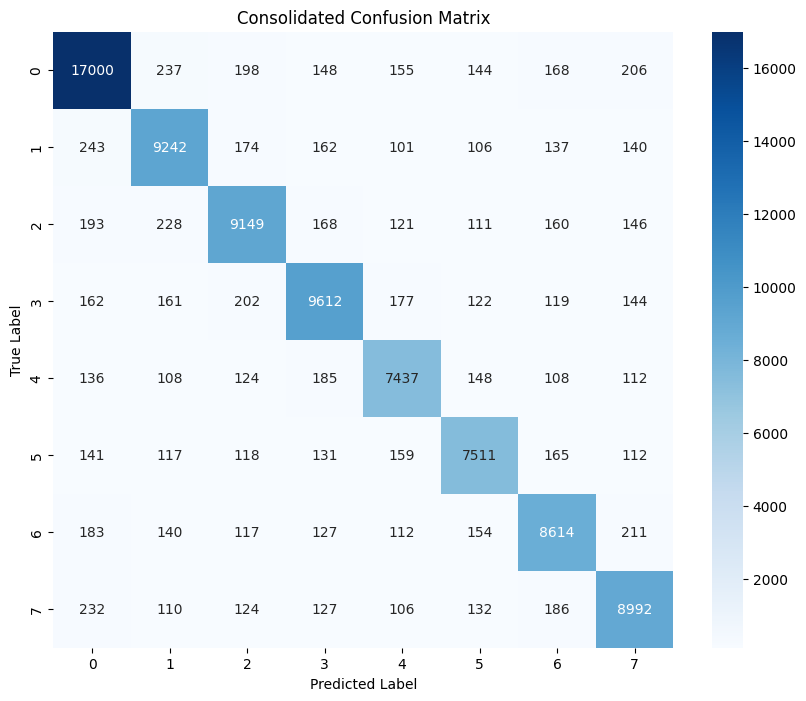

In [ ]:
recall_scores = []
f2_scores = []
prediction_times = []
all_y_true = []
all_y_pred = []

for train_idx, test_idx in cv.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    voting_clone = clone(voting)
    voting_clone.fit(X_train_fold, y_train_fold)

    start_time = time.time()
    y_pred_fold = voting_clone.predict(X_test_fold)
    fold_prediction_time = time.time() - start_time
    prediction_times.append(fold_prediction_time / len(X_test_fold))

    recall_scores.append(recall_score(y_test_fold, y_pred_fold, average='macro'))
    f2_scores.append(fbeta_score(y_test_fold, y_pred_fold, average='macro', beta=2))
    all_y_true.extend(y_test_fold)
    all_y_pred.extend(y_pred_fold)


results = {
    'Recall_macro (Média)': np.mean(recall_scores),
    'Recall_macro (Desvio Padrão)': np.std(recall_scores),
    'F2-Score_macro (Média)': np.mean(f2_scores),
    'F2-Score_macro (Desvio Padrão)': np.std(f2_scores),
    'Tempo de predição por amostra (Média)': np.mean(prediction_times) * 1000,
    'Tempo de predição por amostra (Desvio Padrão)': np.std(prediction_times) * 1000
}

print("\nResultados da Validação Cruzada com VotingClassifier:")
for key, value in results.items():
    print(f"{key}: {value:.4f}")

conf_matrix = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Consolidated Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()